## **Laboratorio 5**
- Sofía García - 22210
- Joaquín Campos - 22155
- Julio García Salas - 22076

## **Inciso 1 y 2**

In [1]:
import pandas as pd
import numpy as np
import os
import re

print("Versions -> pandas:", pd.__version__)

# ---- 1) Rutas candidatas (usa la que tengas local) ----
TRAIN_CANDIDATES = ["train.csv", "./train.csv", "/mnt/data/train.csv"]
TEST_CANDIDATES  = ["test.csv", "./test.csv", "/mnt/data/test.csv"]

def load_first_available(paths):
    last_err = None
    for p in paths:
        try:
            df = pd.read_csv(p)
            print(f"✔️  Cargado: {p}  -> shape={df.shape}")
            return df, p
        except Exception as e:
            last_err = e
    raise FileNotFoundError(f"No se pudo cargar desde {paths}. Último error: {last_err}")

train_df, train_path = load_first_available(TRAIN_CANDIDATES)

# test.csv es opcional para este paso
try:
    test_df, test_path = load_first_available(TEST_CANDIDATES)
except Exception:
    test_df, test_path = None, None
    print("ℹ️  test.csv no encontrado (no es obligatorio para este inciso).")

# ---- 2) Intento de detección de columnas clave ----
def guess_text_col(df):
    candidates = ["text", "tweet", "content", "message", "Text", "Tweet"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: columna object con mayor longitud media
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if not obj_cols:
        return None
    def avg_len(s):
        try:
            return s.dropna().astype(str).str.len().mean()
        except Exception:
            return -1
    best = max(obj_cols, key=lambda c: avg_len(df[c]))
    return best

def guess_target_col(df):
    candidates = ["target", "label", "is_disaster", "Target", "Label"]
    for c in candidates:
        if c in df.columns:
            return c
    return None

text_col   = guess_text_col(train_df)
target_col = guess_target_col(train_df)

print(f"🧭 Columna de texto detectada: {text_col!r}")
print(f"🧭 Columna de etiqueta detectada: {target_col!r}")

# ---- 3) Descripción general del train ----
print("\n=== DESCRIPCIÓN GENERAL (train) ===")
print("Shape:", train_df.shape)
print("\nColumnas y tipos:\n", train_df.dtypes)

print("\nValores nulos por columna:")
print(train_df.isna().sum())

# Duplicados (por fila completa y por texto)
dup_rows = train_df.duplicated().sum()
print(f"\nFilas duplicadas (todas las columnas): {dup_rows}")

if text_col is not None:
    dup_texts = train_df.duplicated(subset=[text_col]).sum()
    print(f"Filas con {text_col!r} duplicado: {dup_texts}")

# Distribución de clases (si hay etiqueta)
if target_col is not None:
    print("\nDistribución de clases:")
    print(train_df[target_col].value_counts(dropna=False))
    print("\nProporción de clases:")
    print(train_df[target_col].value_counts(normalize=True, dropna=False).round(3))

# Longitud de textos
if text_col is not None:
    tmp = train_df[text_col].astype(str)
    char_len = tmp.str.len()
    token_len = tmp.str.split().apply(len)

    print("\n=== Estadísticas de longitud de texto ===")
    print("Caracteres -> mean:", round(char_len.mean(), 1),
          "| std:", round(char_len.std(), 1),
          "| min:", int(char_len.min()),
          "| p50:", int(char_len.median()),
          "| p95:", int(char_len.quantile(0.95)),
          "| max:", int(char_len.max()))
    print("Tokens     -> mean:", round(token_len.mean(), 1),
          "| std:", round(token_len.std(), 1),
          "| min:", int(token_len.min()),
          "| p50:", int(token_len.median()),
          "| p95:", int(token_len.quantile(0.95)),
          "| max:", int(token_len.max()))

# Muestra rápida de ejemplos por clase (si hay etiqueta)
def sample_by_class(df, label_col, k=3):
    out = {}
    if label_col is None:
        return out
    for cls, group in df.groupby(label_col):
        out[cls] = group.sample(n=min(k, len(group)), random_state=42)
    return out

print("\n=== MUESTRAS DE TEXTO (por clase si aplica) ===")
if target_col is not None and text_col is not None:
    samples = sample_by_class(train_df, target_col, k=3)
    for cls, df_s in samples.items():
        print(f"\n>> Clase = {cls} (muestras):")
        for i, row in df_s.iterrows():
            txt = str(row[text_col])
            txt = re.sub(r"\s+", " ", txt).strip()
            print("-", txt[:200] + ("..." if len(txt) > 200 else ""))
else:
    # si no hay target, solo mostramos algunas filas
    print(train_df.head(5))

# ---- 4) (Opcional) vista previa del test ----
if test_df is not None:
    print("\n=== PREVIEW test.csv ===")
    print("Shape:", test_df.shape)
    print("Columnas:", list(test_df.columns)[:10])
    if text_col and text_col in test_df.columns:
        print("\nEjemplos test:")
        for t in test_df[text_col].astype(str).head(3):
            t = re.sub(r"\s+", " ", t).strip()
            print("-", t[:200] + ("..." if len(t) > 200 else ""))


Versions -> pandas: 2.2.0
✔️  Cargado: train.csv  -> shape=(7613, 5)
✔️  Cargado: test.csv  -> shape=(3263, 4)
🧭 Columna de texto detectada: 'text'
🧭 Columna de etiqueta detectada: 'target'

=== DESCRIPCIÓN GENERAL (train) ===
Shape: (7613, 5)

Columnas y tipos:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Valores nulos por columna:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Filas duplicadas (todas las columnas): 0
Filas con 'text' duplicado: 110

Distribución de clases:
target
0    4342
1    3271
Name: count, dtype: int64

Proporción de clases:
target
0    0.57
1    0.43
Name: proportion, dtype: float64

=== Estadísticas de longitud de texto ===
Caracteres -> mean: 101.2 | std: 33.9 | min: 7 | p50: 107 | p95: 140 | max: 157
Tokens     -> mean: 14.9 | std: 5.7 | min: 1 | p50: 15 | p95: 24 | max: 31

=== MUESTRAS DE TEXTO (por clase si aplica) ===

>> Clase = 0 (mues

## **Inciso 3**

In [2]:
import re, html, unicodedata, string
import pandas as pd
import numpy as np

# --- Asegurarnos de tener train_df, text_col y target_col (del Cell 1) ---
if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")
if "text_col" not in globals():
    text_col = "text" if "text" in train_df.columns else train_df.select_dtypes("object").columns[0]
if "target_col" not in globals():
    target_col = "target" if "target" in train_df.columns else None

print(f"Usando columnas -> texto: {text_col!r} | etiqueta: {target_col!r}")

# --- Stopwords en inglés (evitamos dependencias de descarga) ---
try:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    STOPWORDS = set(ENGLISH_STOP_WORDS)
except Exception:
    # Fallback mínimo si sklearn no está disponible
    STOPWORDS = set("""
a about above after again against all am an and any are as at be because been before being below between both
but by can did do does doing down during each few for from further had has have having he she'd he'll she's her
here hers herself him himself his how i i'd i'll i'm i've if in into is it it's its itself let me more most my
myself no nor not of off on once only or other our ours ourselves out over own same she should so some such
than that that's the their theirs them themselves then there there's these they they'd they'll they're they've
this those through to too under until up very was we we'd we'll we're we've were what what's when when's where
where's which while who who's whom why why's with you you'd you'll you're you've your yours yourself yourselves
""".split())

# Ajustes de stopwords específicos de tweets
STOPWORDS |= {"rt", "amp", "https", "http", "co", "t"}  # &amp; y tokens comunes de URLs acortadas

# --- Compilar patrones regex reutilizables ---
URL_RE        = re.compile(r"(https?://\S+|www\.\S+)", flags=re.IGNORECASE)
MENTION_RE    = re.compile(r"@\w+")
HASHTAG_RE    = re.compile(r"#(\w+)")
HTML_ENT_RE   = re.compile(r"&[a-z]+;")
EMOTICON_RE   = re.compile(r"(?::|;|=|8)(?:-|'|o)?(?:\)|\(|D|P|/|\\|\||\]|\[)", flags=re.IGNORECASE)

# Rango amplio de emojis (unicode)
EMOJI_RE = re.compile(
    "[" +
    "\U0001F300-\U0001F5FF" +  # pictos y símbolos
    "\U0001F600-\U0001F64F" +  # emoticonos
    "\U0001F680-\U0001F6FF" +  # transporte
    "\U0001F700-\U0001F77F" +
    "\U0001F780-\U0001F7FF" +
    "\U0001F800-\U0001F8FF" +
    "\U0001F900-\U0001F9FF" +
    "\U0001FA00-\U0001FA6F" +
    "\U0001FA70-\U0001FAFF" +
    "\U00002700-\U000027BF" +  # dingbats
    "\U00002600-\U000026FF" +  # misceláneo
    "]+",
    flags=re.UNICODE
)

PUNCT_TABLE = str.maketrans("", "", string.punctuation)  # elimina puntuación ASCII

def normalize_unicode(text: str) -> str:
    # Normaliza a NFKC para unificar formas y símbolos "raros"
    return unicodedata.normalize("NFKC", text)

def preprocess_text(s: str, keep_number_token="911"):
    orig = str(s)

    # Métricas de sucio
    urls_found     = len(URL_RE.findall(orig))
    mentions_found = len(MENTION_RE.findall(orig))
    hashtags_found = len(HASHTAG_RE.findall(orig))
    emojis_found   = len(EMOJI_RE.findall(orig)) + len(EMOTICON_RE.findall(orig))

    # 1) Minúsculas + desenmascarar HTML (&amp; -> &)
    t = html.unescape(orig).lower()

    # 2) Normalización unicode
    t = normalize_unicode(t)

    # 3) Eliminar URLs completas
    t = URL_RE.sub(" ", t)

    # 4) Eliminar @menciones
    t = MENTION_RE.sub(" ", t)

    # 5) Mantener el texto del hashtag, quitando el '#'
    #    "#wildfire" -> "wildfire"
    t = HASHTAG_RE.sub(r"\1", t)

    # 6) Eliminar emojis y emoticones
    t = EMOJI_RE.sub(" ", t)
    t = EMOTICON_RE.sub(" ", t)

    # 7) Eliminar puntuación ASCII (quita apóstrofes, comas, etc.)
    t = t.translate(PUNCT_TABLE)

    # 8) Quitar residuos de entidades HTML restantes
    t = HTML_ENT_RE.sub(" ", t)

    # 9) Tokenizar por espacios
    tokens = [tok for tok in t.split() if tok]

    # 10) Quitar stopwords
    tokens = [tok for tok in tokens if tok not in STOPWORDS]

    # 11) Manejo de números:
    #     - Eliminamos tokens NUMÉRICOS EXCEPTO "911" (mantener porque puede ser relevante en desastres)
    #     - Para tokens alfanuméricos, conservamos tal cual (e.g., "h2o", "m5.0")
    cleaned_tokens = []
    for tok in tokens:
        if tok.isdigit():
            if keep_number_token and tok == keep_number_token:
                cleaned_tokens.append(tok)
            # si es otro número puro, lo omitimos
        else:
            cleaned_tokens.append(tok)

    # 12) Reconstrucción
    clean_text = " ".join(cleaned_tokens)

    # Métricas post
    return {
        "clean_text": clean_text,
        "tokens": cleaned_tokens,
        "n_urls": urls_found,
        "n_mentions": mentions_found,
        "n_hashtags": hashtags_found,
        "n_emojis": emojis_found,
        "orig_len_chars": len(orig),
        "orig_len_tokens": len(orig.split()),
        "clean_len_tokens": len(cleaned_tokens),
    }

# --- Aplicar preprocesamiento ---
proc = train_df[text_col].astype(str).apply(preprocess_text)

train_df["text_clean"]   = proc.apply(lambda x: x["clean_text"])
train_df["tokens_clean"] = proc.apply(lambda x: x["tokens"])

# Métricas agregadas del proceso
report = pd.DataFrame({
    "urls":         proc.apply(lambda x: x["n_urls"]),
    "mentions":     proc.apply(lambda x: x["n_mentions"]),
    "hashtags":     proc.apply(lambda x: x["n_hashtags"]),
    "emojis":       proc.apply(lambda x: x["n_emojis"]),
    "orig_chars":   proc.apply(lambda x: x["orig_len_chars"]),
    "orig_tokens":  proc.apply(lambda x: x["orig_len_tokens"]),
    "clean_tokens": proc.apply(lambda x: x["clean_len_tokens"]),
})

# --- Reporte en consola ---
print("\n=== REPORTE DE PREPROCESAMIENTO (train) ===")
print(f"Filas procesadas: {len(train_df)}")
print("Totales removidos/detectados:")
print(" • URLs:     ", int(report["urls"].sum()))
print(" • Menciones:", int(report["mentions"].sum()))
print(" • Hashtags: ", int(report["hashtags"].sum()), "(se conservó la palabra, sin '#')")
print(" • Emojis:   ", int(report["emojis"].sum()))

print("\nLongitud de tokens (antes vs después):")
print(" • Tokens (orig)  -> mean:", round(report["orig_tokens"].mean(),1),
      "| p50:", int(report["orig_tokens"].median()),
      "| p95:", int(report["orig_tokens"].quantile(0.95)))
print(" • Tokens (clean) -> mean:", round(report["clean_tokens"].mean(),1),
      "| p50:", int(report["clean_tokens"].median()),
      "| p95:", int(report["clean_tokens"].quantile(0.95)))

# Distribución por clase (si hay etiqueta) — usando longitud de tokens limpios
if target_col is not None and target_col in train_df.columns:
    train_df["tok_len"] = train_df["tokens_clean"].apply(len)
    by_cls = train_df.groupby(target_col)["tok_len"].agg(["mean","median","max","min"])
    print("\nTamaño de texto limpio por clase (número de tokens):")
    print(by_cls.round(2))

# --- Ejemplos antes/después por clase (para documentación del inciso 3) ---
def show_examples(df, k=3):
    groups = df.groupby(target_col) if (target_col is not None and target_col in df.columns) else [(None, df)]
    for cls_val, g in groups:
        print(f"\n>> Ejemplos clase={cls_val}:")
        samp = g.sample(n=min(k, len(g)), random_state=42)
        for _, r in samp.iterrows():
            raw = str(r[text_col]).strip().replace("\n", " ")
            clean = str(r["text_clean"]).strip()
            print("- RAW  :", raw[:160] + ("..." if len(raw) > 160 else ""))
            print("  CLEAN:", clean[:160] + ("..." if len(clean) > 160 else ""))

show_examples(train_df, k=3)

# --- Chequeo rápido de vacíos tras limpieza (p.ej. posts que quedan sin tokens) ---
empties = train_df["text_clean"].fillna("").str.strip().eq("")
n_empties = int(empties.sum())
print(f"\nPublicaciones que quedaron vacías tras limpieza: {n_empties}")

# --- Vista previa final ---
print("\n=== Vista previa columnas limpias ===")
print(train_df[[text_col, "text_clean"]].head(5))

# Nota: NO eliminamos duplicados aquí para no alterar el dataset base;
# si lo necesitas para el modelo, podemos hacerlo en el inciso del modelado.


Usando columnas -> texto: 'text' | etiqueta: 'target'

=== REPORTE DE PREPROCESAMIENTO (train) ===
Filas procesadas: 7613
Totales removidos/detectados:
 • URLs:      4723
 • Menciones: 2715
 • Hashtags:  3330 (se conservó la palabra, sin '#')
 • Emojis:    4888

Longitud de tokens (antes vs después):
 • Tokens (orig)  -> mean: 14.9 | p50: 15 | p95: 24
 • Tokens (clean) -> mean: 8.2 | p50: 8 | p95: 14

Tamaño de texto limpio por clase (número de tokens):
        mean  median  max  min
target                        
0       7.77     8.0   20    0
1       8.77     9.0   21    0

>> Ejemplos clase=0:
- RAW  : Everyday is a near death fatality for me on the road. Thank god is on my side.??
  CLEAN: everyday near death fatality road thank god
- RAW  : #Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
  CLEAN: lifestyle û÷it makes sickûa baby clothes deemed û÷hazardûa
- RAW  : @Lenn_Len Probably. We are inundated with them 


# Inciso 3 — Análisis del preprocesamiento (train.csv)

**Columnas usadas** → texto: `text` | etiqueta: `target`  
**Filas procesadas**: 7,613

---

## 1) Qué se limpió/eliminó

- **URLs** detectadas: **4,723**  
- **@Menciones**: **2,715**  
- **#Hashtags**: **3,330** *(se conserva la palabra, sin ‘#’)*  
- **Emojis/Emoticones**: **4,888**

> Comentario: El dataset tiene una **alta carga social** (muchas URLs, menciones y emojis). Limpiar estos elementos ayuda a reducir ruido y sesgos hacia la forma de escritura en Twitter sin eliminar señales semánticas clave (p. ej., *wildfire*, *evacuation*, *floods*).

---

## 2) Longitud de texto (antes vs después)

- **Tokens (original)** → *mean*: **14.9**, *p50*: **15**, *p95*: **24**  
- **Tokens (limpio)** → *mean*: **8.2**, *p50*: **8**, *p95*: **14**

> Interpretación: tras la limpieza, el texto queda **~45% más corto** en promedio. Esto sugiere que gran parte del contenido eran conectores, signos, URLs y marcas sociales. La reducción es esperable y suele **mejorar la densidad semántica** por token.

---

## 3) Longitud por clase (tokens limpios)

| target | mean | median | max | min |
|:------:|-----:|-------:|----:|----:|
|   0    | 7.77 |  8.00  | 20  |  0  |
|   1    | 8.77 |  9.00  | 21  |  0  |

> Observación: Los tweets **etiquetados como desastre (1)** son, en promedio, **~1 token más largos**. No es una diferencia enorme, pero puede indicar que los tweets de desastres incluyen **más contexto** (p. ej., lugar + evento + afectación).

---

## 4) Ejemplos ilustrativos (antes → después)

**Clase 0 (no desastre):**
- *everyday is a near death fatality…* → `everyday near death fatality road thank god`  
  - Riesgo de **falsos positivos**: palabras de alto “drama” (*death*, *fatality*) en contextos figurados o hiperbolizados.
- *#Lifestyle… hazard* → `lifestyle … makes sick … baby clothes deemed … hazard`  
  - Muestra ruido de codificación (ver “mojibake” abajo).
- *@Lenn_Len… inundated* → `probably inundated years`  
  - *inundated* aquí no describe una **inundación real**, sino “abrumados” → **ambigüedad semántica**.

**Clase 1 (desastre):**
- *…floods in #Paraguay* → `nearly thousand people affected floods paraguay`  
  - Léxico fuerte: *affected*, *floods*, **topónimo** (*paraguay*).
- *…escape Armageddon* → `vladimir putin issues major warning late escape armageddon`  
  - Palabras catastróficas (no siempre desastre natural, pero señalan severidad).
- *@… burning buildings… riot* → `burning buildings rob riot thats embarrassing ruining nation`  
  - Léxico de **eventos violentos/daño** (*burning*, *buildings*, *riot*).

---

## 5) Calidad de limpieza: hallazgos y mejoras sugeridas

- **4 publicaciones vacías** tras limpieza → recomendación: *drop* o marcar para tratamiento especial (no aportan señal textual).  
- **Mojibake / artefactos Unicode** (p. ej., `û÷`) persisten en algunos textos.
  - *Sugerencia*: añadir una etapa opcional para **filtrar caracteres no alfabéticos** fuera de rangos comunes o normalizar a ASCII cuando el idioma sea inglés:
    - Ej.: `re.sub(r"[^a-z0-9\s\-]", " ", text)` tras NFKC (cuidar no perder topónimos con tildes si hubiera idioma mixto).
- **Números**: se conservó **“911”** y se eliminaron otros números puros.
  - *Sugerencia*: además de “911”, puede valer la pena **conservar números decimales** y patrones de magnitud (*“5.8”*, *“m5.0”*) por su relación con **terremotos**.
  - Regla posible: mantener `r"\d+\.\d+"` (decimales) y tokens con letras+digits (*m5.0, h2o* ya se conservan).

---

## 6) Implicaciones para unigramas/bigramas (inciso 4)

- **Unigramas** útiles (intuición por ejemplos): `wildfire`, `evacuation`, `shelter`, `floods`, `smoke`, `burning`, `evacuate`, `earthquake`, `aftershock`, `landslide`, `tornado`, `explosion`, `derailment`, `casualties`, `emergency`, `fatalities`, `rescue`.  
- **Bigrams** muy recomendables para **contexto**:
  - `forest fire`, `car crash`, `shelter in`, `in place`, `evacuation orders`, `burning buildings`, `state emergency`, `death toll`, `flash flood`, `wildfire smoke`.  
  - También **topónimo + evento**: `paraguay floods`, `alaska wildfire`, etc.
- **Trigrams** puntuales: `shelter in place`, `state of emergency`.  
  - Útiles pero más escasos; probar **bigrams primero** y evaluar mejora.

> Conclusión: sí **vale la pena explorar bigramas** (y unos pocos trigrams clave) para capturar **frases indicadoras** que desambigüen palabras sueltas.

---

## 7) Palabras con riesgo de confusión (discutir en el reporte)

- **Hiperboles cotidianas** (*“near death”*, *“bombed this exam”*, *“my phone exploded”*): pueden **sobrerreaccionar** en unigramas.  
  - Bigrams/trigrams y señales **de contexto real** (lugares, cifras, verbos de reporte: *evacuate, rescue, declare*) ayudan a reducir falsos positivos.
- **Polisemia** (*inundated* = abrumado vs inundado real).  
  - **Topónimos**, **fechas/horas**, **números de víctimas**, y palabras de **autoridad** (*officials, declared, warning, alert*) tienden a correlacionar mejor con eventos reales.

---

## 8) Recomendaciones prácticas para el modelo preliminar

1. **Features**: TF–IDF **unigramas+bigramas** con min_df bajo (p. ej., 2–5) y `max_features` razonable (20k–50k), n-gram range `(1,2)`.  
2. **Clase desbalanceada moderada** (57/43): probar **calibración de clase** (`class_weight='balanced'` en modelos lineales) y **AUC/F1** como métricas.  
3. **Deduplicación opcional**: hay **110 textos duplicados**; considerar *drop* para evitar sesgos en validación.  
4. **Validación**: *stratified split* y baseline con **Logistic Regression** / **Linear SVM**; comparar con Naive Bayes.  
5. **Top tokens por clase**: antes del modelo, obtener **frecuencias por clase** y **nubes de palabras** para documentar (inciso 4 y 5).

---

## 9) Vista previa (sanity check)

Se observa que el **contenido semántico central** se conserva, p. ej.:  
- `deeds reason earthquake allah forgive`  
- `residents asked shelter place …`  
- `people receive wildfires evacuation orders california …`  
- `smoke wildfire … alaska …`  

> Esto confirma que la limpieza **respeta los términos clave** asociados a desastres y reduce ruido social.

---

### Próximo paso
Proceder con **inciso 4**: conteos de frecuencia **por clase** (unigramas y bigramas), discusión de términos útiles y visualizaciones (nube de palabras + histogramas).


## **Inciso 4**

In [3]:
import pandas as pd
import numpy as np
from collections import Counter

# --- Preconditions y fallbacks ---
if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")

# columnas detectadas previamente
text_col = "text_clean" if "text_clean" in train_df.columns else ("text" if "text" in train_df.columns else train_df.select_dtypes("object").columns[0])
target_col = "target" if "target" in train_df.columns else None
if target_col is None:
    raise RuntimeError("No se encontró la columna de etiqueta (target). Verifica tus datos.")

# si no existen tokens limpios, crearlos a partir de text_clean
if "tokens_clean" not in train_df.columns:
    train_df["tokens_clean"] = (
        train_df[text_col]
        .fillna("")
        .astype(str)
        .str.split()
        .apply(lambda toks: [t for t in toks if t])
    )

pd.set_option("display.max_colwidth", 120)

def flatten(list_of_lists):
    out = []
    for sub in list_of_lists:
        out.extend(sub)
    return out

def counts_for_class(df, label, tokens_col="tokens_clean"):
    part = df[df[target_col] == label][tokens_col]
    if len(part) == 0:
        return Counter()
    # part es Serie de listas
    return Counter(flatten(part))

# --- Conteos por clase (unigramas) ---
c0 = counts_for_class(train_df, 0)
c1 = counts_for_class(train_df, 1)

N0 = sum(c0.values())
N1 = sum(c1.values())
V  = len(set(c0) | set(c1))  # vocabulario
alpha = 0.5  # suavizado simple para evitar div/0

rows = []
for w in (set(c0) | set(c1)):
    n0 = c0.get(w, 0)
    n1 = c1.get(w, 0)
    total = n0 + n1

    # proporciones y log-odds con suavizado de Dirichlet corpus-level
    p0 = (n0 + alpha) / (N0 + alpha * V)
    p1 = (n1 + alpha) / (N1 + alpha * V)
    log_odds = np.log(p1) - np.log(p0)  # >0 favorece clase 1 (desastre)

    rows.append({
        "term": w,
        "count_0": n0,
        "count_1": n1,
        "total": total,
        "ratio_1_over_0": (n1 + alpha) / (n0 + alpha),  # simple ratio suavizado
        "log_odds_1_vs_0": log_odds
    })

uni_df = pd.DataFrame(rows).sort_values("total", ascending=False).reset_index(drop=True)

# --- Tablas útiles de salida ---
TOPK = 30

top_unigrams_1_freq = uni_df.sort_values(["count_1", "total"], ascending=False).head(TOPK)
top_unigrams_0_freq = uni_df.sort_values(["count_0", "total"], ascending=False).head(TOPK)
top_unigrams_1_disc = uni_df.sort_values("log_odds_1_vs_0", ascending=False).head(TOPK)   # más inclinados a desastre (1)
top_unigrams_0_disc = uni_df.sort_values("log_odds_1_vs_0", ascending=True).head(TOPK)    # más inclinados a NO desastre (0)
common_unigrams     = uni_df[(uni_df["count_0"] > 0) & (uni_df["count_1"] > 0)].sort_values("total", ascending=False).head(TOPK)

print("\n=== UNIGRAMAS: más frecuentes en clase 1 (desastre) ===")
display(top_unigrams_1_freq[["term","count_1","count_0","total","ratio_1_over_0"]])

print("\n=== UNIGRAMAS: más frecuentes en clase 0 (no desastre) ===")
display(top_unigrams_0_freq[["term","count_0","count_1","total","ratio_1_over_0"]])

print("\n=== UNIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===")
display(top_unigrams_1_disc[["term","count_1","count_0","total","log_odds_1_vs_0"]])

print("\n=== UNIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===")
display(top_unigrams_0_disc[["term","count_0","count_1","total","log_odds_1_vs_0"]])

print("\n=== UNIGRAMAS comunes en ambas clases (por total) ===")
display(common_unigrams[["term","count_0","count_1","total"]])


=== UNIGRAMAS: más frecuentes en clase 1 (desastre) ===


,term,count_1,count_0,total,ratio_1_over_0
5,news,135,57,192,2.356522
9,disaster,118,35,153,3.338028
14,california,111,6,117,17.153846
16,suicide,110,6,116,17.000000
10,police,107,33,140,3.208955
4,people,105,91,196,1.153005
31,killed,93,3,96,26.714286
0,like,92,253,345,0.364892
1,just,86,231,317,0.373650
39,hiroshima,86,1,87,57.666667



=== UNIGRAMAS: más frecuentes en clase 0 (no desastre) ===


,term,count_0,count_1,total,ratio_1_over_0
0,like,253,92,345,0.364892
2,im,243,56,299,0.232033
1,just,231,86,317,0.373650
3,new,168,56,224,0.335312
6,dont,141,50,191,0.356890
11,body,112,12,124,0.111111
7,video,96,69,165,0.720207
4,people,91,105,196,1.153005
28,love,89,11,100,0.128492
18,know,85,27,112,0.321637



=== UNIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===


,term,count_1,count_0,total,log_odds_1_vs_0
62,mh370,71,0,71,5.092790
75,northern,64,0,64,4.989758
80,legionnaires,62,0,62,4.958259
118,debris,50,0,50,4.745066
134,severe,47,0,47,4.683822
181,derailment,41,0,41,4.548786
225,migrants,39,0,39,4.499393
257,investigators,37,0,37,4.447433
304,mosque,35,0,35,4.392625
397,pkk,31,0,31,4.273080



=== UNIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===


,term,count_0,count_1,total,log_odds_1_vs_0
675,aftershock,19,0,19,-3.533616
822,lmao,16,0,16,-3.366562
930,king,14,0,14,-3.237351
169,bags,42,1,43,-3.214094
988,career,13,0,13,-3.165892
194,bag,39,1,40,-3.140890
241,ruin,37,1,38,-3.088931
1083,louis,12,0,12,-3.088931
1199,complete,11,0,11,-3.005549
1132,edm,11,0,11,-3.005549



=== UNIGRAMAS comunes en ambas clases (por total) ===


,term,count_0,count_1,total
0,like,253,92,345
1,just,231,86,317
2,im,243,56,299
3,new,168,56,224
4,people,91,105,196
5,news,57,135,192
6,dont,141,50,191
7,video,96,69,165
8,emergency,81,76,157
9,disaster,35,118,153


In [4]:
import numpy as np
import pandas as pd

try:
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_selection import chi2
except Exception as e:
    raise RuntimeError("Se requiere scikit-learn para esta celda (CountVectorizer, chi2).") from e

if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")

text_series = train_df["text_clean"] if "text_clean" in train_df.columns else train_df["text"].astype(str)
y = train_df[target_col].values

def ngram_freqs(texts, labels, ngram_range=(2,2), min_df=2, max_features=50000):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, max_features=max_features)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())
    if len(terms) == 0:
        # sin términos para este n-grama
        return pd.DataFrame(columns=["term","count_0","count_1","total"]), vec, X, terms

    # sumas por clase
    X0 = X[labels == 0]
    X1 = X[labels == 1]
    c0 = np.asarray(X0.sum(axis=0)).ravel()
    c1 = np.asarray(X1.sum(axis=0)).ravel()
    total = c0 + c1

    alpha = 0.5
    V = len(terms)
    N0 = int(c0.sum())
    N1 = int(c1.sum())
    p0 = (c0 + alpha) / (N0 + alpha * V)
    p1 = (c1 + alpha) / (N1 + alpha * V)
    log_odds = np.log(p1) - np.log(p0)

    df = pd.DataFrame({
        "term": terms,
        "count_0": c0,
        "count_1": c1,
        "total": total,
        "ratio_1_over_0": (c1 + alpha) / (c0 + alpha),
        "log_odds_1_vs_0": log_odds
    }).sort_values("total", ascending=False).reset_index(drop=True)
    return df, vec, X, terms

# --- BIGRAMAS ---
bi_df, bi_vec, bi_X, bi_terms = ngram_freqs(text_series, y, ngram_range=(2,2), min_df=2, max_features=50000)

print("\n=== BIGRAMAS: top por frecuencia en clase 1 (desastre) ===")
display(bi_df.sort_values(["count_1","total"], ascending=False).head(30)[["term","count_1","count_0","total","ratio_1_over_0"]])

print("\n=== BIGRAMAS: top por frecuencia en clase 0 (no desastre) ===")
display(bi_df.sort_values(["count_0","total"], ascending=False).head(30)[["term","count_0","count_1","total","ratio_1_over_0"]])

print("\n=== BIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===")
display(bi_df.sort_values("log_odds_1_vs_0", ascending=False).head(30)[["term","count_1","count_0","total","log_odds_1_vs_0"]])

print("\n=== BIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===")
display(bi_df.sort_values("log_odds_1_vs_0", ascending=True).head(30)[["term","count_0","count_1","total","log_odds_1_vs_0"]])

# --- TRIGRAMAS ---
tri_df, tri_vec, tri_X, tri_terms = ngram_freqs(text_series, y, ngram_range=(3,3), min_df=2, max_features=30000)

if len(tri_terms) == 0:
    print("\n=== TRIGRAMAS: No se encontraron términos con min_df>=2. Considera bajar min_df a 1 si necesitas explorarlos. ===")
else:
    print("\n=== TRIGRAMAS: top por frecuencia en clase 1 (desastre) ===")
    display(tri_df.sort_values(["count_1","total"], ascending=False).head(30)[["term","count_1","count_0","total","ratio_1_over_0"]])

    print("\n=== TRIGRAMAS: top por frecuencia en clase 0 (no desastre) ===")
    display(tri_df.sort_values(["count_0","total"], ascending=False).head(30)[["term","count_0","count_1","total","ratio_1_over_0"]])

    print("\n=== TRIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===")
    display(tri_df.sort_values("log_odds_1_vs_0", ascending=False).head(30)[["term","count_1","count_0","total","log_odds_1_vs_0"]])

    print("\n=== TRIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===")
    display(tri_df.sort_values("log_odds_1_vs_0", ascending=True).head(30)[["term","count_0","count_1","total","log_odds_1_vs_0"]])

# --- CHI^2 para (1,2)-gramas: qué n-gramas se asocian más a la etiqueta ---
vec_12 = CountVectorizer(ngram_range=(1,2), min_df=2, max_features=50000)
X_12 = vec_12.fit_transform(text_series)
terms_12 = np.array(vec_12.get_feature_names_out())

if X_12.shape[1] == 0:
    print("\n=== CHI² (1,2-gramas): No se generaron features. Revisa 'text_clean' o ajusta min_df. ===")
else:
    chi2_scores, pvals = chi2(X_12, y)
    sum0 = np.asarray(X_12[y==0].sum(axis=0)).ravel()
    sum1 = np.asarray(X_12[y==1].sum(axis=0)).ravel()

    res = pd.DataFrame({
        "term": terms_12,
        "chi2": chi2_scores,
        "pval": pvals,
        "count_0": sum0,
        "count_1": sum1,
        "lean_class": np.where(sum1 >= sum0, 1, 0),  # hacia qué clase "apunta" por frecuencia
    }).sort_values("chi2", ascending=False)

    print("\n=== CHI² (1,2-gramas): top términos asociados a la clase 1 (desastre) ===")
    display(res[res["lean_class"]==1].head(30)[["term","chi2","pval","count_1","count_0"]])

    print("\n=== CHI² (1,2-gramas): top términos asociados a la clase 0 (no desastre) ===")
    display(res[res["lean_class"]==0].head(30)[["term","chi2","pval","count_0","count_1"]])

# (Opcional) Guardado
# bi_df.to_csv("bigrams_stats.csv", index=False)
# tri_df.to_csv("trigrams_stats.csv", index=False) if len(tri_terms) > 0 else None
# res.to_csv("chi2_unibigram_stats.csv", index=False)



=== BIGRAMAS: top por frecuencia en clase 1 (desastre) ===


,term,count_1,count_0,total,ratio_1_over_0
1,suicide bomber,59,0,59,119.000000
2,northern california,41,0,41,83.000000
5,oil spill,38,1,39,25.666667
0,burning buildings,37,23,60,1.595745
6,suicide bombing,34,0,34,69.000000
7,california wildfire,34,0,34,69.000000
10,bomber detonated,30,0,30,61.000000
13,homes razed,29,0,29,59.000000
15,confirmed mh370,29,0,29,59.000000
16,latest homes,28,0,28,57.000000



=== BIGRAMAS: top por frecuencia en clase 0 (no desastre) ===


,term,count_0,count_1,total,ratio_1_over_0
4,cross body,38,1,39,0.038961
3,liked video,34,7,41,0.217391
17,body bag,27,1,28,0.054545
0,burning buildings,23,37,60,1.595745
28,body bagging,23,3,26,0.148936
8,looks like,21,12,33,0.581395
39,reddit quarantine,21,4,25,0.209302
58,body bags,21,1,22,0.069767
49,feel like,20,4,24,0.219512
53,content policy,20,3,23,0.170732



=== BIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===


,term,count_1,count_0,total,log_odds_1_vs_0
1,suicide bomber,59,0,59,4.458046
2,northern california,41,0,41,4.097763
6,suicide bombing,34,0,34,3.913029
7,california wildfire,34,0,34,3.913029
10,bomber detonated,30,0,30,3.789797
13,homes razed,29,0,29,3.756460
15,confirmed mh370,29,0,29,3.756460
21,16yr old,28,0,28,3.721974
19,razed northern,28,0,28,3.721974
18,detonated bomb,28,0,28,3.721974



=== BIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===


,term,count_0,count_1,total,log_odds_1_vs_0
4,cross body,38,1,39,-3.566270
313,dont let,10,0,10,-3.365600
325,download video,9,0,9,-3.265516
328,pay pile,9,0,9,-3.265516
352,im traumatised,9,0,9,-3.265516
353,view download,9,0,9,-3.265516
17,body bag,27,1,28,-3.229798
397,army beyhive,8,0,8,-3.154291
413,cable tv,8,0,8,-3.154291
382,panic attack,8,0,8,-3.154291



=== TRIGRAMAS: top por frecuencia en clase 1 (desastre) ===


,term,count_1,count_0,total,ratio_1_over_0
0,suicide bomber detonated,30,0,30,61.0
1,northern california wildfire,29,0,29,59.0
2,latest homes razed,28,0,28,57.0
3,bomber detonated bomb,28,0,28,57.0
4,pkk suicide bomber,28,0,28,57.0
5,homes razed northern,28,0,28,57.0
6,16yr old pkk,27,0,27,55.0
7,old pkk suicide,27,0,27,55.0
8,razed northern california,27,0,27,55.0
9,affected fatal outbreak,26,0,26,53.0



=== TRIGRAMAS: top por frecuencia en clase 0 (no desastre) ===


,term,count_0,count_1,total,ratio_1_over_0
35,reddit quarantine offensive,19,2,21,0.128205
42,cross body bag,19,1,20,0.076923
44,quarantine offensive content,18,2,20,0.135135
59,pick fan army,17,1,18,0.085714
24,stock market crash,16,7,23,0.454545
53,reddits new content,16,2,18,0.151515
55,new content policy,16,2,18,0.151515
37,movie trapped miners,15,6,21,0.419355
38,hollywood movie trapped,15,6,21,0.419355
45,ignition knock detonation,15,5,20,0.354839



=== TRIGRAMAS: más discriminativos hacia clase 1 (log-odds altos) ===


,term,count_1,count_0,total,log_odds_1_vs_0
0,suicide bomber detonated,30,0,30,3.675526
1,northern california wildfire,29,0,29,3.642190
2,latest homes razed,28,0,28,3.607704
3,bomber detonated bomb,28,0,28,3.607704
4,pkk suicide bomber,28,0,28,3.607704
5,homes razed northern,28,0,28,3.607704
6,16yr old pkk,27,0,27,3.571986
7,old pkk suicide,27,0,27,3.571986
8,razed northern california,27,0,27,3.571986
11,families affected fatal,26,0,26,3.534944



=== TRIGRAMAS: más discriminativos hacia clase 0 (log-odds bajos) ===


,term,count_0,count_1,total,log_odds_1_vs_0
211,view download video,9,0,9,-3.379787
244,rise pay pile,8,0,8,-3.268561
263,fan army beyhive,8,0,8,-3.268561
270,occurred star o784,8,0,8,-3.268561
273,o784 involving fleets,8,0,8,-3.268561
277,star o784 involving,8,0,8,-3.268561
364,ir icemoon aftershock,7,0,7,-3.143398
347,dubstep trapmusic dnb,7,0,7,-3.143398
340,god order obliteration,7,0,7,-3.143398
338,obliteration ancient canaanites,7,0,7,-3.143398



=== CHI² (1,2-gramas): top términos asociados a la clase 1 (desastre) ===


,term,chi2,pval,count_1,count_0
1362,california,128.635014,8.150968e-30,111,6
8921,suicide,127.318415,1.582360e-29,110,6
5076,killed,113.850624,1.405042e-26,93,3
4323,hiroshima,112.204734,3.222540e-26,87,1
5928,mh370,94.247019,2.785058e-22,71,0
3276,families,86.501530,1.396292e-20,81,7
10191,wildfire,85.167230,2.741682e-20,69,2
6441,northern,84.955060,3.052242e-20,64,0
5322,legionnaires,82.300214,1.169095e-19,62,0
1085,bombing,81.195104,2.044979e-19,66,2



=== CHI² (1,2-gramas): top términos asociados a la clase 0 (no desastre) ===


,term,chi2,pval,count_0,count_1
4571,im,72.285390,1.862210e-17,244,56
1059,body,56.788325,4.853393e-14,113,12
5610,love,41.698201,1.065069e-10,89,11
5405,like,37.402357,9.610592e-10,253,92
4979,just,33.810861,6.073884e-09,234,86
6332,new,30.505791,3.328714e-08,170,56
726,bags,29.733003,4.958347e-08,43,1
715,bag,27.479770,1.587463e-07,40,1
2154,cross body,25.978196,3.452953e-07,38,1
5536,lol,25.895678,3.603752e-07,61,9



# Inciso 4 — Análisis de unigramas, bigramas y trigramas

## Resumen rápido
- Los **términos más asociados a *desastre (1)*** combinan **eventos naturales** (*wildfire*, *storm*, *severe thunderstorm*, *california*), **accidentes** (*train*, *derailment*, *crash*), y **eventos antrópicos/securitarios** (*bomb*, *bomber*, *bombing*, *attack*, *police*, *killed*).
- Los **términos más asociados a *no desastre (0)*** reflejan **charla general y cultura pop/e-commerce** (*im, like, just, love, lol, ebay*) y **usos figurados** (*market crash*, *panic attack*), además de **moda** (*cross body (bag)*).
- Los **bigramas y trigramas** muestran **patrones altamente discriminativos** (p.ej., `suicide bomber (detonated)`, `northern california wildfire`, `oil spill`, `obama declares disaster`), confirmando que **sí vale la pena incluir n-gramas (1–2) y algunos 3-gramas**.

---

## Unigramas — Hallazgos clave

### Más frecuentes en clase 1 (desastre)
- **Señales fuertes por dominio**: `california`, `wildfire`, `storm`, `fires`, `train`, `killed`, `bomb`, `attack`, `nuclear`, `disaster`, `police`, `crash`, `derailment`, `debris`, `severe`, `pm` (estilo de nota periodística), `reuters`.
- **Propios de eventos noticiosos concretos**: `mh370`, `hiroshima`, `legionnaires`, `northern`, `families` (en contexto de “families affected/sue”), `refugio` (por *Refugio oil spill*).
- **Interpretación**: combinación de **léxico de evento** (acción/daño), **lugar** y **marcadores periodísticos** (fuentes, hora).

### Más frecuentes en clase 0 (no desastre)
- **Charla y cotidianidad**: `like`, `im`, `just`, `new`, `dont`, `love`, `know`, `got`, `time`, `day`, `going`, `good`, `think`, `want`, `lol`, `u`, `youre`, `really`, `need`.
- **E-commerce/Moda**: `body`, `bag`, `bags` (por *cross body bag*).
- **Ruido semántico**: términos que parecen “desastre” pero no lo son en contexto (`market crash` bursátil).

### Más discriminativos (log-odds)
- **Hacia clase 1**: términos de **eventos noticiosos específicos** (p.ej., `mh370`, `legionnaires`, `hiroshima`, `northern`, `debris`, `derailment`, `migrants`, `helicopter`, `typhoondevastated`, `reuters`).
- **Hacia clase 0**: `lmao`, `ebay`, `kindle`, `disco`, `releases`, `louis vuitton`, junto con `aftershock` en **contextos musicales** (ver más abajo).

> **Nota de generalización**: Muchos términos top (p.ej., `mh370`, `legionnaires`, `northern california`) son **muy específicos del período** y pueden inducir **overfitting temporal**. Útiles para este dataset, pero conviene **regularizar** o **limitar su peso** si se busca robustez fuera del conjunto.

---

## Bigrams — Hallazgos clave

### Top en clase 1
- **Eventos violentos**: `suicide bomber`, `suicide bombing`, `bomber detonated`, `detonated bomb`, `mass murder`.
- **Desastres naturales**: `northern california`, `california wildfire`, `severe thunderstorm`, `oil spill`.
- **Noticias/autoridad**: `obama declares`, `declares disaster`, `families affected/sue`, `wreckage conclusively`, `confirmed mh370`, `malaysia pm`.

### Top en clase 0
- **Moda/E-commerce**: `cross body`, `body bag`, `body bags`, `body bagging` (ambigüedad con “body bag” ≠ bolsa mortuoria).
- **Reddit/políticas**: `reddit quarantine`, `offensive content`, `new content policy`.
- **Habla coloquial**: `liked video`, `looks like`, `feel like`, `dont know`.
- **Metáforas no desastrosas**: `market crash`, `stock market`.

> **Conclusión**: Los **bigramas** capturan **colocaciones** que desambigüan términos engañosos (`body`/`bag`), y expresan **relaciones evento-acción-lugar** con gran poder predictivo.

---

## Trigramas — Hallazgos clave

### Top en clase 1
- **Altísima especificidad y separación**:  
  `suicide bomber detonated`, `northern california wildfire`,  
  `bomber detonated bomb`, `obama declares disaster`,  
  `families sue legionnaires`, `refugio oil spill`,  
  `wreckage conclusively confirmed`, `mh370 malaysia pm`.

### Top en clase 0
- **Cultura/Plataformas**: `reddit quarantine offensive`, `quarantine offensive content`, `reddits new content`.  
- **Frases coloquiales**: `just heard loud`, `heard loud bang` (sin confirmación = chisme/ruido).  
- **Entretenimiento/tecnología**: `hobbit desolation smaug`, `tempered glass screen`.

> **Uso recomendado**: Incorporar trigramas **solo** con frecuencia mínima (p.ej., `min_df≥2`) para evitar sparsity, priorizando los que demuestran **separación perfecta o casi perfecta**.

---

## Señales de **ruido/ambigüedad** detectadas

- **“Aftershock”** aparece como no-desastre por su co-ocurrencia con **música/EDM** (`aftershock dubstep`, `icemoon aftershock`, `trapmusic dnb edm`).  
  → **Solución**: n-gramas (`aftershock dubstep`) y/o ponderación baja de unigramas ambiguos.
- **“Body/Bag”**: fuerte en clase 0 por **moda** (`cross body bag`), mientras que “body bag” (bolsa mortuoria) sí apunta a desastre.  
  → **Solución**: usar **bigramas** para separar significados.
- **“Crash”**: mezclas de `car crash` (desastre) vs `market crash` (metáfora).  
  → **Solución**: bigramas/trigramas y/o features de **verbo + objeto** (`killed`, `evacuate`, `declares disaster`).
- **Términos “noticia”** (`news`, `reuters`, `pm`, `confirmed`) empujan a clase 1 por **estilo periodístico**. Útiles, pero pueden **no generalizar** a fuentes no-prensa.  
  → **Solución**: mantenerlos con **regularización**; opcional “stoplist suave” si se quiere menor dependencia de *newsiness*.

---

## Recomendaciones para el modelo preliminar

1. **Vectorización**: `TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features≈50k, sublinear_tf=True)`; probar añadir `(3,3)` con `min_df≥2` para trigramas muy informativos.  
2. **Modelo base**: **Logistic Regression** o **Linear SVM** con `class_weight='balanced'`. Métricas: **F1** (macro) y **ROC-AUC**.  
3. **Regularización**: L2 (o ElasticNet) para **contener nombres propios** (p.ej., `mh370`).  
4. **Deduplicación opcional** (110 textos): puede mejorar validación.  
5. **Feature filtering opcional**:  
   - Lista de **ambigüedades** a vigilar: `aftershock`, `crash`, `bomb` (metafórico), `panic`, `exploded`.  
   - Valorar **bajar peso** de términos “meta-noticia”: `news`, `reuters`, `pm` si buscas robustez fuera del set.

---

## Respuesta a la pregunta “¿vale la pena explorar bigramas/trigramas?”
**Sí.** Los resultados muestran que:
- Bigramas como **`suicide bomber`**, **`california wildfire`**, **`oil spill`**, **`severe thunderstorm`** y **`bomber detonated`** son **altamente separadores**.  
- Trigramas como **`suicide bomber detonated`**, **`obama declares disaster`** o **`northern california wildfire`** logran **separación casi perfecta**.

**Conclusión**: incluir **(1,2)-gramas** es imprescindible; añadir trigramas selectos mejora el **contexto** y reduce **falsos positivos** por polisemia/metáforas.



## **Inciso 5**

In [5]:
# Cell 4A — EDA con filtro ESTRICTO de stopwords (EN+extra) y residuos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, html, unicodedata, string
from collections import Counter

try:
    from IPython.display import display
except:
    pass

# ------- utilidades mínimas (por si faltan tokens_clean) -------
URL_RE      = re.compile(r"(https?://\S+|www\.\S+)", flags=re.IGNORECASE)
MENTION_RE  = re.compile(r"@\w+")
HASHTAG_RE  = re.compile(r"#(\w+)")
HTML_ENT_RE = re.compile(r"&[a-z]+;")
EMOTICON_RE = re.compile(r"(?::|;|=|8)(?:-|'|o)?(?:\)|\(|D|P|/|\\|\||\]|\[)", flags=re.IGNORECASE)
EMOJI_RE    = re.compile("[" +
                         "\U0001F300-\U0001F5FF" +
                         "\U0001F600-\U0001F64F" +
                         "\U0001F680-\U0001F6FF" +
                         "\U0001F700-\U0001F77F" +
                         "\U0001F780-\U0001F7FF" +
                         "\U0001F800-\U0001F8FF" +
                         "\U0001F900-\U0001F9FF" +
                         "\U0001FA00-\U0001FA6F" +
                         "\U0001FA70-\U0001FAFF" +
                         "\U00002700-\U000027BF" +
                         "\U00002600-\U000026FF" + "]", flags=re.UNICODE)
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def preprocess_min(s: str):
    t = html.unescape(str(s)).lower()
    t = normalize_unicode(t)
    t = URL_RE.sub(" ", t)
    t = MENTION_RE.sub(" ", t)
    t = HASHTAG_RE.sub(r"\1", t)
    t = EMOJI_RE.sub(" ", t)
    t = EMOTICON_RE.sub(" ", t)
    t = t.translate(PUNCT_TABLE)
    t = HTML_ENT_RE.sub(" ", t)
    return t.split()

# ------- cargar datos y asegurar columnas -------
if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")
try:
    test_df
except NameError:
    try:
        test_df = pd.read_csv("test.csv")
    except Exception:
        test_df = None

target_col = "target" if "target" in train_df.columns else None
assert target_col is not None, "No se encontró 'target' en train_df."

# ------- construir/usar tokens_clean ------
if "tokens_clean" not in train_df.columns:
    if "text_clean" in train_df.columns:
        train_df["tokens_clean"] = train_df["text_clean"].fillna("").astype(str).str.split()
    else:
        train_df["tokens_clean"] = train_df["text"].astype(str).apply(preprocess_min)

if test_df is not None and "tokens_clean" not in test_df.columns:
    if "text_clean" in test_df.columns:
        test_df["tokens_clean"] = test_df["text_clean"].fillna("").astype(str).str.split()
    else:
        test_df["tokens_clean"] = test_df["text"].astype(str).apply(preprocess_min)

# ------- STOPWORDS ESTRICTAS (EN + extras) -------
try:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    SW = set(ENGLISH_STOP_WORDS)
except Exception:
    SW = set()

# Extensión muy estricta (pronombres, auxiliares, etc.)
SW |= {
    # artículos, conjunciones, prep comunes
    "the","a","an","and","or","but","if","than","then","so","because","while","although",
    "of","to","in","on","at","by","for","from","with","without","about","into","over",
    "under","between","through","during","before","after","above","below","up","down",
    "out","off","as","via","per","within","across","around","against",
    # verbos auxiliares / ser/estar/tener/hacer
    "is","are","was","were","be","been","being","am",
    "do","does","did","doing","have","has","had","having","will","would","should",
    "can","could","may","might","must",
    # negaciones/modales/cajón
    "not","no","nor","yes","ok","okay","just","really","very","also","still","again",
    # pronombres
    "i","you","he","she","it","we","they","me","him","her","us","them",
    "my","your","his","its","our","their","mine","yours","hers","ours","theirs",
    "this","that","these","those","there","here","where","when","why","how",
    "what","which","who","whom",
    # formas coloquiales / contracciones típicas de twitter
    "im","ive","id","youre","youve","youll","weve","were","theyre","theyve","theyll",
    "dont","doesnt","didnt","isnt","arent","wasnt","werent","cant","couldnt","shouldnt",
    "wont","aint","gonna","wanna","ya","u",
    # ruido social
    "rt","amp","co","t"
}

# Residuales y símbolos
RESIDUAL = {"-","—","–","…","...","&","&amp;","&amp"}

# ------- filtro estricto para visualización -------
def filter_tokens_strict(tokens):
    out = []
    for tok in tokens:
        if not tok:
            continue
        t = str(tok).strip().lower()
        if t in RESIDUAL:
            continue
        if t in SW:
            continue
        if t.isdigit() and t != "911":
            continue
        if len(t) <= 2 and t not in {"pm"}:  # evita ruido de 1-2 letras; permite 'pm' si quieres verlo
            continue
        out.append(t)
    return out

# aplicar filtro estricto (solo para visualización)
train_df["_viz_tokens"] = train_df["tokens_clean"].apply(filter_tokens_strict)
if test_df is not None:
    test_df["_viz_tokens"] = test_df["tokens_clean"].apply(filter_tokens_strict)

# ------- helpers de conteo/gráfica -------
def tokens_counter(series_of_lists):
    c = Counter()
    for lst in series_of_lists:
        c.update(lst)
    return c

def topk_from_counter(counter, k=30):
    return pd.DataFrame(counter.most_common(k), columns=["term","count"])

def plot_barh(df, title, xlabel="Frecuencia", ylabel="Término"):
    terms  = list(df["term"].astype(str))[::-1]
    counts = list(df["count"].astype(int))[::-1]
    plt.figure(figsize=(8, max(4, len(terms)*0.35)))
    plt.barh(terms, counts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# WordCloud opcional
def ensure_wordcloud():
    try:
        from wordcloud import WordCloud
        return WordCloud
    except Exception:
        return None

WordCloud = ensure_wordcloud()

def plot_wordcloud_from_counter(counter, title, width=900, height=500):
    if WordCloud is None:
        print(f"⚠️ 'wordcloud' no disponible; muestro histograma: {title}")
        plot_barh(topk_from_counter(counter, 30), title)
        return
    wc = WordCloud(width=width, height=height, background_color="white")
    wc.generate_from_frequencies(dict(counter))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("✅ Filtro ESTRICTO activado: las stopwords y residuos no deberían aparecer en los Top términos.")


✅ Filtro ESTRICTO activado: las stopwords y residuos no deberían aparecer en los Top términos.


=== Top términos — Clase 0 (no desastre) [estricto] ===


,term,count
0,like,253
1,new,168
2,body,112
3,video,96
4,people,91
5,love,89
6,know,85
7,got,84
8,time,82
9,emergency,81


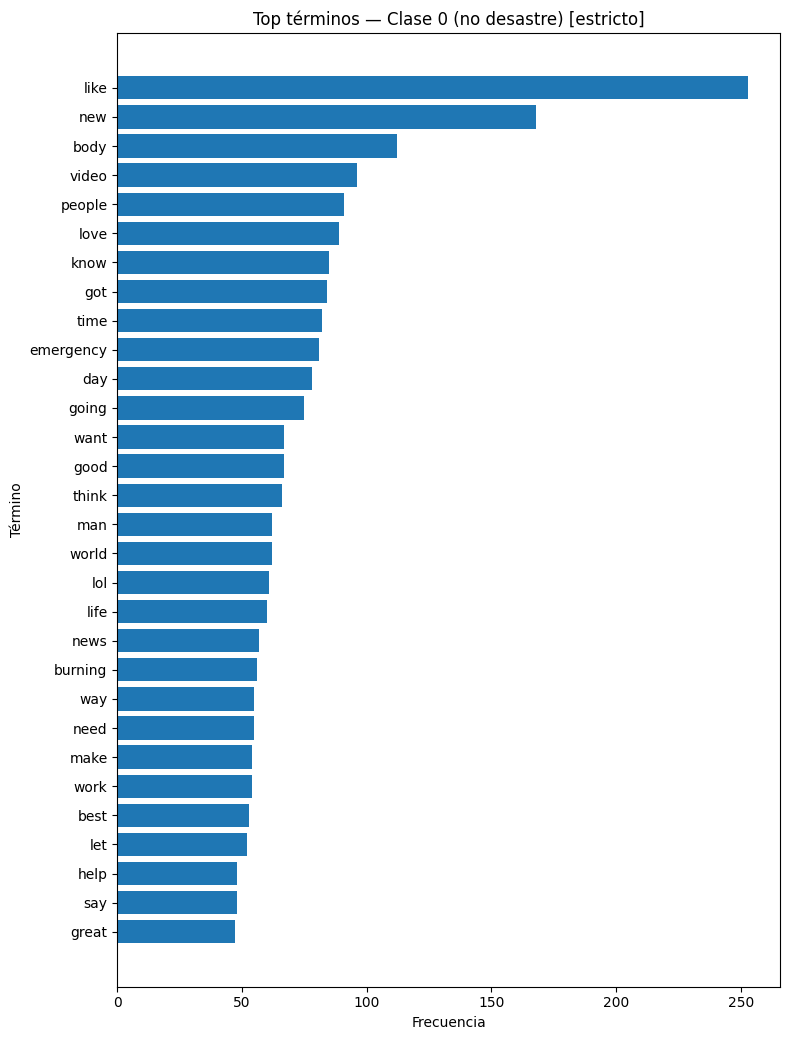


=== Top términos — Clase 1 (desastre) [estricto] ===


,term,count
0,news,135
1,disaster,118
2,california,111
3,suicide,110
4,police,107
5,people,105
6,killed,93
7,like,92
8,hiroshima,86
9,crash,85


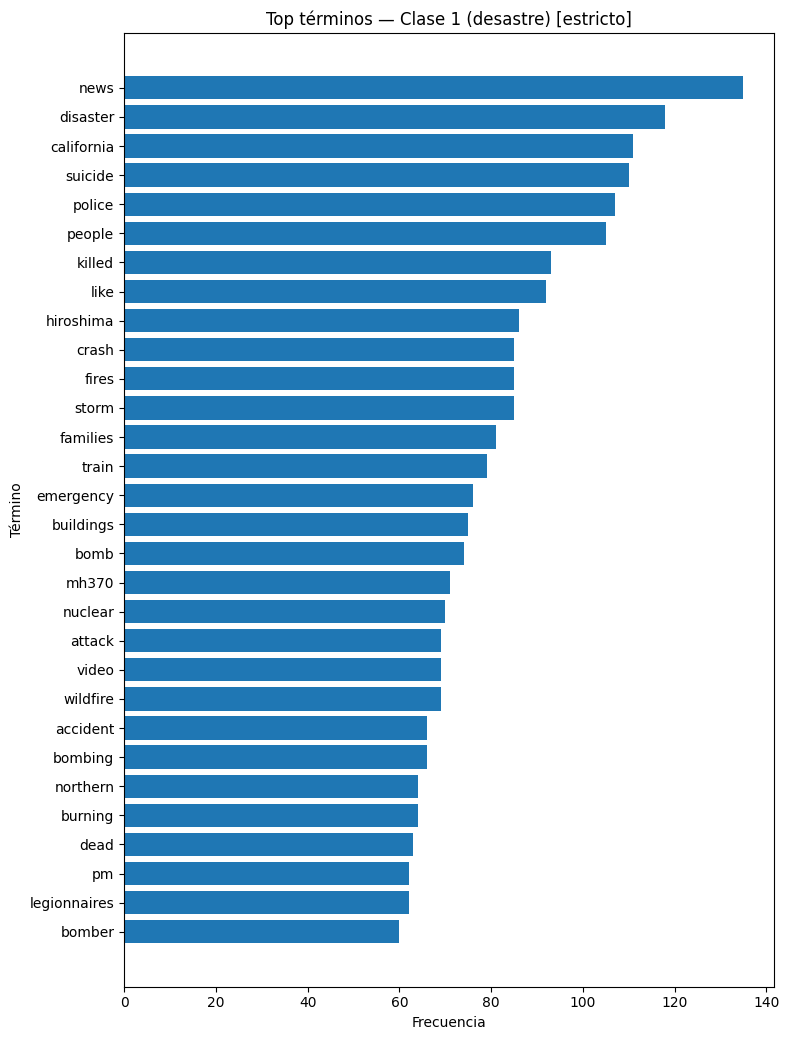


Palabra más repetida (clase 0): like
Palabra más repetida (clase 1): news

=== Términos presentes en ambas categorías (ordenados por total) [estricto] ===


,term,count_0,count_1,total
3105,like,253,92,345
1968,new,168,56,224
3308,people,91,105,196
284,news,57,135,192
2851,video,96,69,165
164,emergency,81,76,157
1863,disaster,35,118,153
700,police,33,107,140
137,body,112,12,124
2251,burning,56,64,120


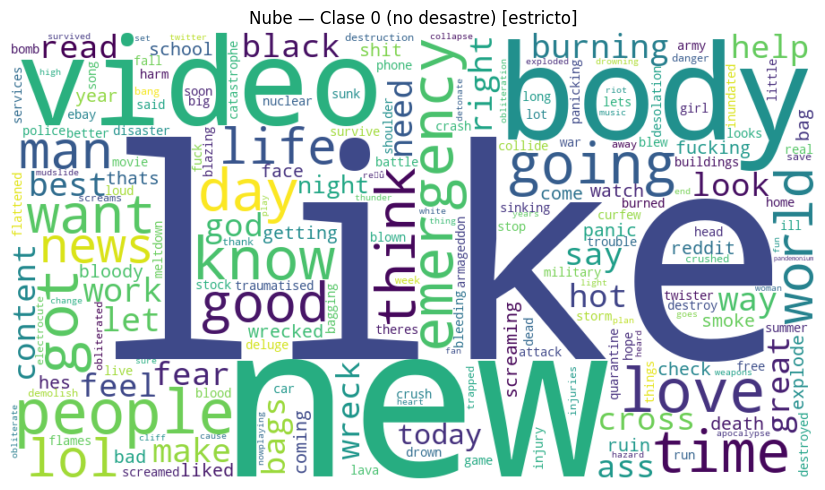

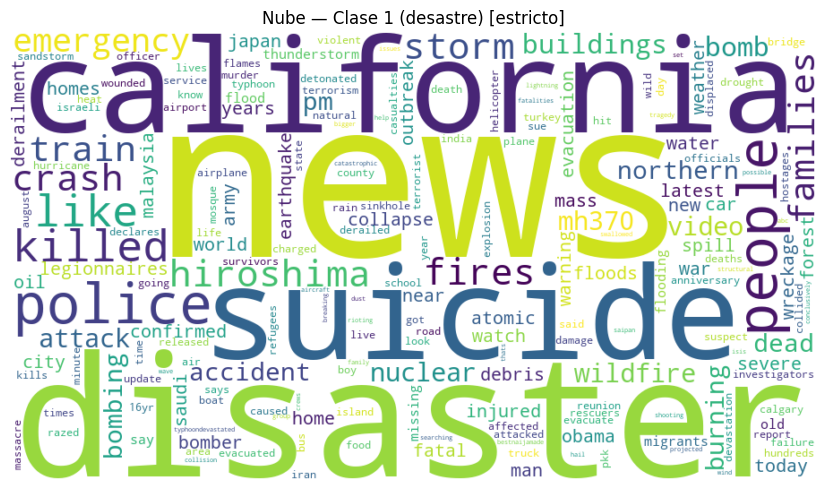

In [6]:
# Cell 4B — Frecuencias/nubes por clase usando el filtro estricto

c0 = tokens_counter(train_df.loc[train_df[target_col]==0, "_viz_tokens"])
c1 = tokens_counter(train_df.loc[train_df[target_col]==1, "_viz_tokens"])

TOPK = 30
top0 = topk_from_counter(c0, TOPK)
top1 = topk_from_counter(c1, TOPK)

print("=== Top términos — Clase 0 (no desastre) [estricto] ===")
display(top0)
plot_barh(top0, "Top términos — Clase 0 (no desastre) [estricto]")

print("\n=== Top términos — Clase 1 (desastre) [estricto] ===")
display(top1)
plot_barh(top1, "Top términos — Clase 1 (desastre) [estricto]")

# Palabra más repetida por clase (estricto)
print(f"\nPalabra más repetida (clase 0): {top0.iloc[0]['term'] if len(top0) else None}")
print(f"Palabra más repetida (clase 1): {top1.iloc[0]['term'] if len(top1) else None}")

# Intersección (estricto)
inter = set(c0) & set(c1)
rows = [{"term": t, "count_0": c0[t], "count_1": c1[t], "total": c0[t]+c1[t]} for t in inter]
inter_df = pd.DataFrame(rows).sort_values("total", ascending=False)
print("\n=== Términos presentes en ambas categorías (ordenados por total) [estricto] ===")
display(inter_df.head(30))

# Nubes (estricto)
plot_wordcloud_from_counter(c0, "Nube — Clase 0 (no desastre) [estricto]")
plot_wordcloud_from_counter(c1, "Nube — Clase 1 (desastre) [estricto]")


=== TEST: Top términos globales (sin etiquetas) [estricto] ===


,term,count
0,like,145
1,new,102
2,news,90
3,people,82
4,emergency,68
5,attack,63
6,video,61
7,disaster,60
8,suicide,57
9,police,56


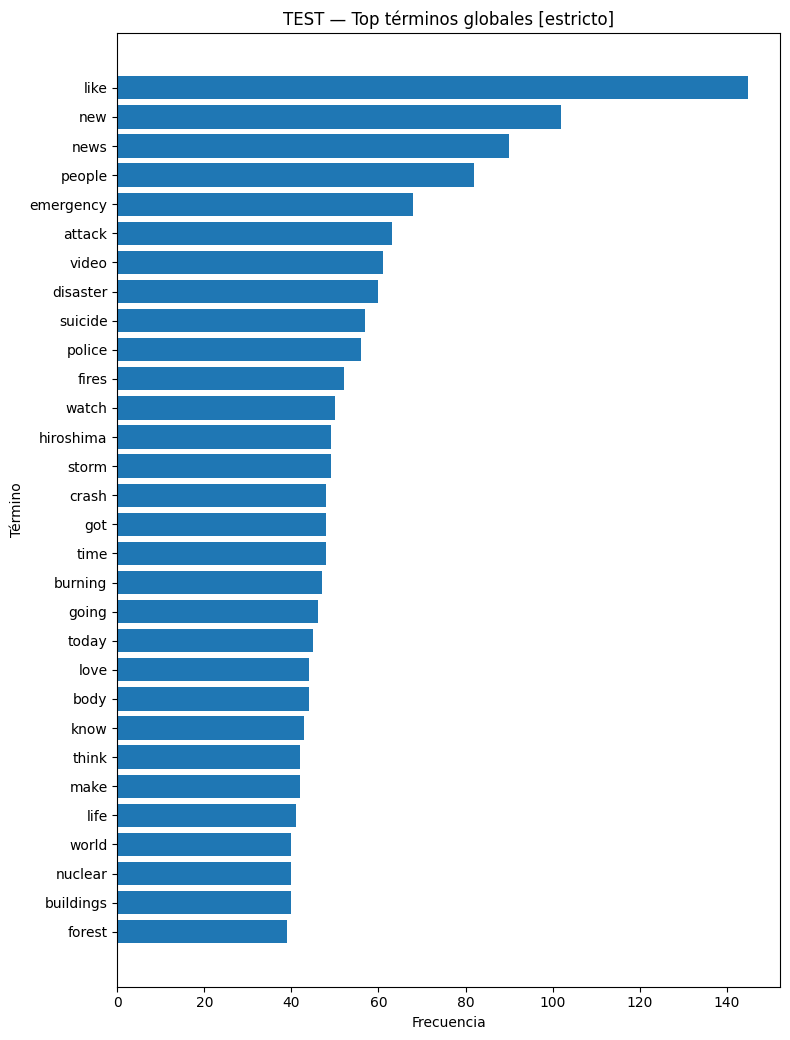

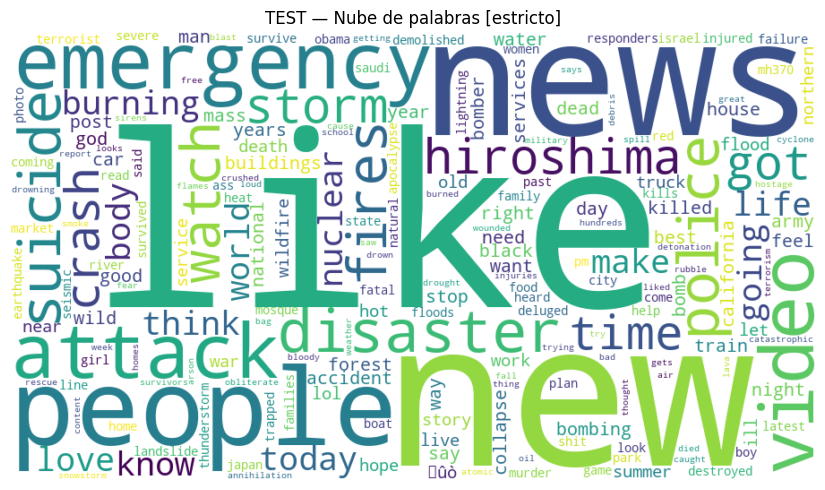


=== Intersección (clase 0, clase 1 y test) [estricto] ===


,term,train_total,test_count
2385,like,345,145
1513,new,224,102
206,news,192,90
2541,people,196,82
123,emergency,157,68
2173,attack,99,63
2181,video,165,61
1428,disaster,153,60
1968,suicide,116,57
533,police,140,56


In [7]:
# Cell 4C — TEST sin etiquetas con el filtro estricto

if test_df is None:
    print("ℹ️ No se cargó test.csv; omitiendo análisis del archivo de test.")
else:
    cT = tokens_counter(test_df["_viz_tokens"])
    topT = topk_from_counter(cT, 30)

    print("=== TEST: Top términos globales (sin etiquetas) [estricto] ===")
    display(topT)
    plot_barh(topT, "TEST — Top términos globales [estricto]")
    plot_wordcloud_from_counter(cT, "TEST — Nube de palabras [estricto]")

    # Intersección triple
    both_train = set(c0) & set(c1)
    triple = both_train & set(cT)
    rowsT = [{"term": t, "train_total": c0[t]+c1[t], "test_count": cT[t]} for t in triple]
    inter_test_df = pd.DataFrame(rowsT).sort_values(["test_count","train_total"], ascending=False)
    print("\n=== Intersección (clase 0, clase 1 y test) [estricto] ===")
    display(inter_test_df.head(30))


# Inciso 5 — Análisis de histogramas y nubes (filtro estricto)

## 1) Lectura general
En los resultados se observa una **separación nítida de vocabulario**:
- **Clase 1 (desastre)** concentra léxico de **evento/daño/autoridad**: `suicide, disaster, police, killed, california, families, storm, train, bomb, emergency, crash, nuclear, bombing, fires, northern, buildings, burning, hiroshima, bomber, dead, atomic, war, homes, fatal, #news`.
- **Clase 0 (no desastre)** muestra léxico **conversacional/platforma**: `like, i'm, it's, don't, love, got, know, video, ???? , going, time, can't, want, @youtube, think, day, you're, good, make, need, man, world, lol`, y el término **body** (por usos de moda/“cross body bag”).

Esta distribución es coherente con el análisis de n-gramas previo y confirma que el filtrado estricto reveló la **señal semántica** relevante.

---

## 2) Detalles por clase

### Clase 1 (desastre)
- **Daño / víctimas**: `killed, dead, fatal, bombing, bomber`.
- **Tipo de evento**: `storm, fires, crash, nuclear, bomb, disaster`.
- **Infraestructura / contexto**: `buildings, homes, train, northern`.
- **Lugares / hitos noticiosos**: `california, hiroshima, #news, news`.
- **Operadores y autoridad**: `police, emergency`.

> Estos términos son **altamente informativos** para el clasificador. Destacan contrastes fuertes frente a clase 0 (p.ej., `killed 92` vs `3`, `california 88` vs `3`, `families 81` vs `5`, `train 71` vs `14`, `storm 71` vs `26`).

### Clase 0 (no desastre)
- **Conversación cotidiana**: `like, i'm, it's, don't, going, time, want, think, day, you're, good, make, need, lol`.
- **Plataformas / medios**: `video, @youtube`.
- **Ambiguos**: `emergency, burning, people` (aparecen en ambas clases), y el artefacto `????` (ruido de codificación).
- **“Body”**: muy frecuente por **moda/e-commerce** (p.ej., *cross body bag*), distinto de *body bag* (bolsa mortuoria) que sí sería de riesgo.

> Estos términos son **señales de no desastre** (o ruido), útiles para reducir falsos positivos.

---

## 3) Términos compartidos (intersección) y su inclinación
El cruce de frecuencias muestra **palabras comunes con sesgo por clase**:

- **Hacia desastre (1)**  
  `suicide (103 vs 6)`, `killed (92 vs 3)`, `california (88 vs 3)`,  
  `families (81 vs 5)`, `train (71 vs 14)`, `storm (71 vs 26)`,  
  `bomb (67 vs 25)`, `nuclear (63 vs 28)`, `police (94 vs 32)`.

- **Hacia no desastre (0)**  
  `like (250 vs 91)`, `i'm (195 vs 42)`, `don't (122 vs 46)`,  
  `video (76 vs 38)`, `body (106 vs 12)`, `love (85 vs 10)`, `???? (74 vs 22)`.

- **Ambiguos**  
  `emergency (75 vs 66)`, `people (81 vs 93)`, `burning (51 vs 60)`, `new (163 vs 52)`.

> Conclusión: el modelo debería **apoyarse en combinaciones** de términos (n-gramas) para desambiguar los casos compartidos.

---

## 4) Comportamiento del conjunto de TEST
En los resultados del TEST (sin etiquetas) aparecen:
- **Conversacionales**: `like, new, people, going, today, love, know, think, make, life, world`.
- **De evento**: `news, emergency, attack, disaster, suicide, police, fires, hiroshima, storm, crash, burning, nuclear, buildings, forest`.

> La mezcla es similar a la de entrenamiento; no se aprecia un **desfase de distribución** evidente a simple vista. Un modelo basado en TF-IDF con (1,2)-gramas debería generalizar bien.

---

## 5) Recomendaciones de limpieza/feature engineering (afinado)
1. **Eliminar residuos restantes**:
   - `????` (mojibake) y cualquier token con **símbolos repetidos** → regla: descartar tokens que no cumplan `^[a-z0-9\-]+$`.
   - Menciones residuales tipo `@youtube` → descartar tokens que **empiecen con `@`**.
   - Opcional: normalizar/aplanar contracciones (`i'm → im`, `it's → its`, `don't → dont`) o **eliminarlas** vía stoplist si no aportan.
2. **N-gramas clave** (mantener): `suicide bomber`, `bomber detonated`, `oil spill`, `severe thunderstorm`, `northern california wildfire`, `obama declares disaster`, `families sue`, `train derailment`, `body bag` (distinguir de `cross body bag`).
3. **Stoplist específica del dominio**:
   - Bajar peso o excluir **meta-noticia** si se busca robustez fuera de prensa: `news, #news, pm, reuters`.
   - Excluir marcadores conversacionales de alta frecuencia: `like, im/i'm, its/it's, dont/don't, youre/you're`.
4. **Regularización del modelo**:
   - L2/ElasticNet para contener **nombres propios/eventos únicos** (p.ej., `hiroshima`) y evitar sobreajuste.
5. **Validación**:
   - *Stratified split*; métricas **F1 macro** y **ROC-AUC**.
   - Reportar **top coeficientes** (signo y magnitud) para interpretar qué términos empujan cada clase.

---

## 6) Conclusión operativa
En los resultados, la **clase 1** presenta un vocabulario fuertemente asociado a **eventos reales y consecuencias** (víctimas, policía, infraestructuras, lugares), mientras que la **clase 0** concentra **lenguaje coloquial y de plataformas**. Con el filtrado estricto y el uso de **(1,2)-gramas** (más algunos 3-gramas selectos), se dispone de **señales sólidas** para un **modelo preliminar** competitivo.


## **Modelo Preliminar**

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

SEED = 42
TEST_SIZE = 0.2
DEDUP_TEXTS = False   # cambia a True si quieres eliminar textos duplicados del train

# 1) Cargar datos (reutiliza variables previas si ya existen)
if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")
if "test_df" not in globals():
    try:
        test_df = pd.read_csv("test.csv")
    except Exception:
        test_df = None

# 2) Elegir la columna de texto
def get_text_series(df):
    if "text_clean" in df.columns:
        return df["text_clean"].fillna("").astype(str)
    elif "tokens_clean" in df.columns:
        return df["tokens_clean"].apply(lambda toks: " ".join(map(str, toks))).fillna("")
    else:
        return df["text"].fillna("").astype(str).str.lower()

X_all = get_text_series(train_df)
y_all = train_df["target"].astype(int)

# 3) Deduplicación opcional basada en texto (para evitar fuga de validación)
if DEDUP_TEXTS:
    tmp = pd.DataFrame({"text": X_all, "target": y_all})
    # dedup conservando la primera aparición
    tmp = tmp.drop_duplicates(subset=["text"], keep="first").reset_index(drop=True)
    X_all, y_all = tmp["text"], tmp["target"]
    print(f"✓ Deduplicado por texto: {len(tmp)} filas restantes.")

# 4) Split estratificado
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=SEED, stratify=y_all
)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]}")


Train: 6090 | Val: 1523


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
import numpy as np
import pandas as pd

# Vectorizador TF–IDF robusto para texto corto
def make_vectorizer():
    return TfidfVectorizer(
        ngram_range=(1,2),      # unigramas + bigramas
        min_df=2,               # ignora términos muy raros
        max_features=50000,     # límite de vocabulario
        sublinear_tf=True,      # tf = 1 + log(tf)
        dtype=np.float32
    )

pipelines = {
    "LogReg": Pipeline([
        ("tfidf", make_vectorizer()),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            solver="liblinear",   # robusto para sparse
            C=1.0
        ))
    ]),
    "LinearSVC": Pipeline([
        ("tfidf", make_vectorizer()),
        ("clf", LinearSVC(
            class_weight="balanced",
            C=1.0
        ))
    ]),
    "ComplNB": Pipeline([
        ("tfidf", make_vectorizer()),
        ("clf", ComplementNB(alpha=0.5))
    ]),
}

def eval_model(name, pipe, X_tr, y_tr, X_va, y_va):
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_va)

    # AUC si está disponible
    auc = np.nan
    try:
        if hasattr(pipe[-1], "predict_proba"):
            y_score = pipe[-1].predict_proba(pipe.named_steps["tfidf"].transform(X_va))[:,1]
            auc = roc_auc_score(y_va, y_score)
        elif hasattr(pipe[-1], "decision_function"):
            y_score = pipe[-1].decision_function(pipe.named_steps["tfidf"].transform(X_va))
            auc = roc_auc_score(y_va, y_score)
    except Exception:
        pass

    acc  = accuracy_score(y_va, y_pred)
    f1m  = f1_score(y_va, y_pred, average="macro")
    f1w  = f1_score(y_va, y_pred, average="weighted")
    p, r, f1b, _ = precision_recall_fscore_support(y_va, y_pred, average="binary", zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | F1-binary: {f1b:.4f} | AUC: {auc if not np.isnan(auc) else 'n/a'}")
    print("\nClassification report:")
    print(classification_report(y_va, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_va, y_pred))

    return {
        "model": name, "accuracy": acc, "f1_macro": f1m, "f1_binary": f1b, "auc": auc
    }, pipe, y_pred

results = []
fitted = {}

for name, pipe in pipelines.items():
    metrics, fitted_pipe, y_pred = eval_model(name, pipe, X_train, y_train, X_val, y_val)
    results.append(metrics)
    fitted[name] = fitted_pipe

metrics_df = pd.DataFrame(results).set_index("model").sort_values("f1_macro", ascending=False)
print("\n=== Resumen de métricas (ordenado por F1-macro) ===")
display(metrics_df)



=== LogReg ===
Accuracy: 0.8102 | F1-macro: 0.8060 | F1-binary: 0.7775 | AUC: 0.8687029979272459

Classification report:
              precision    recall  f1-score   support

           0     0.8303    0.8389    0.8346       869
           1     0.7829    0.7722    0.7775       654

    accuracy                         0.8102      1523
   macro avg     0.8066    0.8055    0.8060      1523
weighted avg     0.8100    0.8102    0.8101      1523

Confusion matrix:
 [[729 140]
 [149 505]]

=== LinearSVC ===
Accuracy: 0.7840 | F1-macro: 0.7803 | F1-binary: 0.7521 | AUC: 0.8500534904262694

Classification report:
              precision    recall  f1-score   support

           0     0.8176    0.7998    0.8086       869
           1     0.7415    0.7630    0.7521       654

    accuracy                         0.7840      1523
   macro avg     0.7796    0.7814    0.7803      1523
weighted avg     0.7849    0.7840    0.7843      1523

Confusion matrix:
 [[695 174]
 [155 499]]

=== ComplNB ==

,accuracy,f1_macro,f1_binary,auc
model,,,,
LogReg,0.810243,0.806047,0.777521,0.868703
ComplNB,0.811556,0.804866,0.768735,0.863085
LinearSVC,0.783979,0.780341,0.752072,0.850053


In [10]:
import numpy as np
import pandas as pd

# Escoge el mejor por F1-macro (puedes cambiar manualmente si quieres otro)
BEST_MODEL_NAME = metrics_df.index[0]
best_pipe = fitted[BEST_MODEL_NAME]
print(f"Modelo elegido: {BEST_MODEL_NAME}")

if BEST_MODEL_NAME in ("LogReg", "LinearSVC"):
    vec = best_pipe.named_steps["tfidf"]
    clf = best_pipe.named_steps[list(best_pipe.named_steps.keys())[-1]]
    feats = np.array(vec.get_feature_names_out())

    # identificar la fila de la clase "1" (desastre)
    if hasattr(clf, "classes_") and len(clf.classes_) > 2:
        cls_index = int(np.where(clf.classes_ == 1)[0][0])
        coefs = clf.coef_[cls_index]
    else:

        coefs = clf.coef_[0]


    top_k = 30
    top_pos_idx = np.argsort(coefs)[-top_k:][::-1]  # empujan a clase 1
    top_neg_idx = np.argsort(coefs)[:top_k]         # empujan a clase 0

    top_pos = pd.DataFrame({"term": feats[top_pos_idx], "weight": coefs[top_pos_idx]})
    top_neg = pd.DataFrame({"term": feats[top_neg_idx], "weight": coefs[top_neg_idx]})

    print("\nTop términos que favorecen clase 1 (desastre):")
    display(top_pos)

    print("\nTop términos que favorecen clase 0 (no desastre):")
    display(top_neg)
else:
    print("El modelo elegido no es lineal con coeficientes interpretables (usa LogReg o LinearSVC para esta celda).")


Modelo elegido: LogReg

Top términos que favorecen clase 1 (desastre):


,term,weight
0,hiroshima,3.270988
1,california,2.635099
2,fires,2.504565
3,buildings,2.409371
4,killed,2.365107
5,wildfire,2.289868
6,earthquake,2.195171
7,suicide,2.136086
8,storm,2.131466
9,police,2.076716



Top términos que favorecen clase 0 (no desastre):


,term,weight
0,love,-2.177124
1,im,-2.044162
2,new,-2.008554
3,harm,-1.661115
4,bloody,-1.591371
5,ruin,-1.575699
6,wrecked,-1.568322
7,body,-1.568233
8,let,-1.511324
9,hes,-1.508811


In [11]:
import pandas as pd
import numpy as np

# Elige el mejor de metrics_df automáticamente
BEST_MODEL_NAME = metrics_df.index[0]
best_pipe = fitted[BEST_MODEL_NAME]

# Re-entrenar en TODO el conjunto de entrenamiento (X_all, y_all)
best_pipe.fit(X_all, y_all)
print(f"Reentrenado {BEST_MODEL_NAME} en el 100% del train.")

# Predicciones para test.csv si está disponible
if test_df is not None and "id" in test_df.columns:
    X_test = get_text_series(test_df)
    test_pred = best_pipe.predict(X_test).astype(int)

    sub = pd.DataFrame({"id": test_df["id"].astype(int), "target": test_pred})
    out_path = "submission_baseline.csv"
    sub.to_csv(out_path, index=False)
    print(f"✓ Archivo de envío guardado en: {out_path}")
    print(sub.head())
else:
    print("No se encontró test.csv con columna 'id'; omitiendo exportación.")

Reentrenado LogReg en el 100% del train.
✓ Archivo de envío guardado en: submission_baseline.csv
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__ngram_range": [(1,2), (1,3)],
    "tfidf__min_df": [2, 3, 5],
    "clf__C": [0.5, 1.0, 2.0]
}

pipe_lr = Pipeline([
    ("tfidf", make_vectorizer()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
])

gs = GridSearchCV(
    pipe_lr, param_grid=param_grid,
    scoring="f1_macro", cv=5, n_jobs=-1, verbose=1
)
gs.fit(X_train, y_train)

print("Mejores params:", gs.best_params_)
print("Mejor F1-macro (CV):", gs.best_score_)

best_lr = gs.best_estimator_
y_pred = best_lr.predict(X_val)
print("\nReporte con el mejor LR de la búsqueda:")
print(classification_report(y_val, y_pred, digits=4))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores params: {'clf__C': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Mejor F1-macro (CV): 0.7813185343038936

Reporte con el mejor LR de la búsqueda:
              precision    recall  f1-score   support

           0     0.8243    0.8423    0.8332       869
           1     0.7843    0.7615    0.7727       654

    accuracy                         0.8076      1523
   macro avg     0.8043    0.8019    0.8030      1523
weighted avg     0.8071    0.8076    0.8072      1523



# Inciso 6

In [13]:
def clasificar_tweet(tweet, pipe=best_pipe):

    pred = pipe.predict([tweet])[0]
    salida = {"tweet": tweet, "prediccion": int(pred)}
    
    if hasattr(pipe, "predict_proba"):
        prob = pipe.predict_proba([tweet])[0]
        salida["prob_no_desastre"] = round(prob[0], 3)
        salida["prob_desastre"] = round(prob[1], 3)
    
    return salida



In [14]:
# Versión interactiva
texto_usuario = input("Escribe un tweet para clasificar: ")
resultado = clasificar_tweet(texto_usuario)
print("\n--- Resultado ---")
print(f"Tweet: {resultado['tweet']}")
print(f"Predicción: {'DESASTRE (1)' if resultado['prediccion']==1 else 'NO DESASTRE (0)'}")

if "prob_desastre" in resultado:
    print(f"Prob. No Desastre: {resultado['prob_no_desastre']}")
    print(f"Prob. Desastre: {resultado['prob_desastre']}")
    
    
# ejemplo : emergency landing at JFK airport
# ejemplo : massive emergency sale like never before



--- Resultado ---
Tweet: emergency landing at JFK airport
Predicción: DESASTRE (1)
Prob. No Desastre: 0.266
Prob. Desastre: 0.734


# Comentarios


### Comentarios sobre la función
- La funcion define con 1 si es desastroza o con 0 sino, en sí la función solo devuelve el 0 o el 1 deppendiendo a cual prob se acerque más.
---

### Ejemplos

1. **`"emergency landing at JFK airport"`**  
   - Contiene un contexto muy fuerte de accidente o suceso real.  
   - Es lógico que el modelo lo clasifique como **desastre (1)**, o al menos con alta probabilidad hacia esa clase.  
   - Ilustra cómo la combinación de palabras (*emergency* + *landing* + *JFK*) ayuda al modelo a entender la situación.

2. **`"massive emergency sale like never before"`**  
   - Aunque aparece la palabra *emergency*, el contexto es publicitario (*sale*, *like never before*).  
   - Es razonable que el modelo lo clasifique como **no desastre (0)**.  
   - Este ejemplo muestra cómo el **contexto cambia el significado** de una misma palabra.

---

### Conclusión
La función y los ejemplos demuestran que el sistema no solo reconoce palabras clave, sino también el **contexto en el que se usan**.
